# Fine supervision

This notebooks explains step-by-step how the custom dataset is build - based on already implemented coarse supervision

In [3]:
import sys

sys.path.append("c:\\Users\\robin\\Documents\\HyperBrain")
sys.path.append("c:\\Users\\robin\\Documents\\HyperBrain\\source")

In [17]:
from source.datasets.brain_dataset import BrainDataset
import torch

In [5]:
crop_size = 640
transformation_threshold = 0.15
patch_size = 16
max_translation_shift = 50
fine_feature_size = 160
images_directory = "../../data/cyto_downscaled_3344_3904/"

dataset_train = BrainDataset(
    images_directory=images_directory,
    train=True,
    transformation_threshold=transformation_threshold,
    crop_size=crop_size,
    patch_size=patch_size,
    max_translation_shift=max_translation_shift,
    fine_feature_size=fine_feature_size,
)

The refinement process is designed to build upon the foundation established by coarse matching. Consequently, it commences with the previously discussed coarse matches, specifically utilizing the match_matrix. The primary objective of this step is to identify matches with a higher degree of accuracy than what is achievable through coarse matching alone.

In [7]:
(
    image_1_crop,
    image_2_crop,
    match_matrix,
    relative_coordinates,
    crop_coordinate_mapping,
) = dataset_train[0]

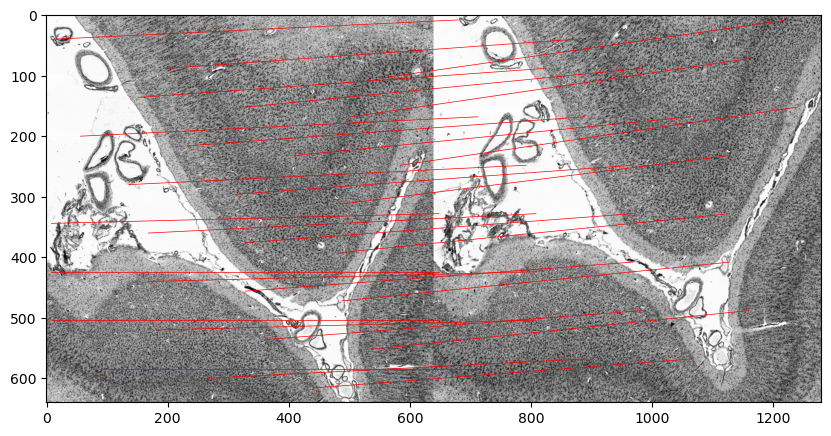

In [9]:
from source.visualization.image_visualization import (
    plot_images_with_matches_via_match_matrix,
)

plot_images_with_matches_via_match_matrix(
    image_1=image_1_crop,
    image_2=image_2_crop,
    match_matrix=match_matrix,
    visualization_mode="lines",
)

In [10]:
# Get matched patches in crop 1 and crop 2
crop_1_patch_indices = match_matrix.nonzero()[:, 0]  # Get all patch indices in crop 1
crop_2_patch_indices = match_matrix.nonzero()[:, 1]  # Get all patch indices in crop 2

In [14]:
# Number of matches should be the same
crop_1_patch_indices.shape, crop_2_patch_indices.shape

(torch.Size([1400]), torch.Size([1400]))

In [16]:
# Where are the matches (in patch indices)?
crop_1_patch_indices

tensor([  80,   81,   82,  ..., 1597, 1598, 1599])

In [18]:
from source.data_processing.patch_processing import get_patch_coordinates

# Translate patch indices back to coordinates in crop space

# Translate patch indices back to coordinates
# Get mid point of patches in crop 1 and crop 2
crop_1_patch_mid_indices = (
    get_patch_coordinates(patch_indices=crop_1_patch_indices)
    + torch.Tensor([8, 8]).long()
)  # Get all patch coordinates in crop 1 and add 8 to get the mid point of the patch
crop_2_patch_mid_indices = (
    get_patch_coordinates(patch_indices=crop_2_patch_indices)
    + torch.Tensor([8, 8]).long()
)  # Get all patch coordinates in crop 2 and add 8 to get the mid point of the patch

In [20]:
crop_1_patch_mid_indices, crop_1_patch_mid_indices.shape

(tensor([[  8,  40],
         [ 24,  40],
         [ 40,  40],
         ...,
         [600, 632],
         [616, 632],
         [632, 632]]),
 torch.Size([1400, 2]))

In [21]:
from source.data_processing.transformations import translate_fine_to_coarse

# Translate the mid points of patches in crop 1 and 2 to the fine feature space
# NOTE: Fine feature space (160 channel) is 'coarse' compared to the crop space (640 channel)
crop_1_patch_mid_indices_fine = translate_fine_to_coarse(
    crop_1_patch_mid_indices, coarse_size=160, fine_size=640
)
crop_2_patch_mid_indices_fine = translate_fine_to_coarse(
    crop_2_patch_mid_indices, coarse_size=160, fine_size=640
)

In [23]:
crop_1_patch_mid_indices_fine, crop_1_patch_mid_indices_fine.shape

(tensor([[  2,  10],
         [  6,  10],
         [ 10,  10],
         ...,
         [150, 158],
         [154, 158],
         [158, 158]]),
 torch.Size([1400, 2]))

So far we just computed the mid pixel of each patch and translated these to the fine feature space. But for the supervision we need to know where some mid pixel of crop 1 went exactly due to the transformation:

In [24]:
# Before we computed the mid point of the patches in crop 1 and 2.
# This block computes where the mid point of crop 1 went exactly in crop 2 through the affine transformation.
crop_1_mid_pixels_transformation = crop_coordinate_mapping[
    crop_1_patch_mid_indices[:, 1], crop_1_patch_mid_indices[:, 0]
]
crop_1_mid_pixels_transformation_fine = translate_fine_to_coarse(
    crop_1_mid_pixels_transformation, coarse_size=160, fine_size=640
)

In [25]:
# We now have the mid pixels in crop 2 and the coordinates of the exact match in crop 2
# This is an important difference since a mid pixel of crop 1 is not necessarily
# transformed to a mid pixel in crop 2, obviously (all in fine feature space).
# The following shows this differences (Note that we want to learn this difference):
crop_2_patch_mid_indices_fine, crop_1_mid_pixels_transformation_fine

(tensor([[ 10,   2],
         [ 14,   2],
         [ 18,   2],
         ...,
         [146, 142],
         [150, 142],
         [154, 138]]),
 tensor([[ 10,   2],
         [ 14,   1],
         [ 18,   1],
         ...,
         [144, 140],
         [148, 140],
         [152, 139]]))

The printed tensors above show that there is a difference in a mid point of crop 2 and a transformed mid point of crop 1 - even if they come from the same patch

In [28]:
from source.data_processing.transformations import get_relative_coordinates

# Compute the relative coordinates of the exact match in crop 2 wrt the mid pixel of crop 2
relative_coordinates = get_relative_coordinates(
    transformed_coordinates=crop_1_mid_pixels_transformation_fine,
    reference_coordinates=crop_2_patch_mid_indices_fine,
)
relative_coordinates

tensor([[ 0.0000,  0.0000],
        [ 0.0000, -0.5000],
        [ 0.0000, -0.5000],
        ...,
        [-1.0000, -1.0000],
        [-1.0000, -1.0000],
        [-1.0000,  0.5000]])

### Interpretation relative coordinates

|          |         |       |         |        |
|----------|---------|-------|---------|--------|
| -1, -1   | -0.5, -1| 0, -1 | 0.5, -1 | 1, -1  |
| -1, -0.5 | -0.5,-0.5| 0, -0.5| 0.5, -0.5| 1, -0.5|
| -1, 0    | -0.5, 0 | 0, 0  | 0.5, 0  | 1, 0   |
| -1, 0.5  | -0.5, 0.5| 0, 0.5| 0.5, 0.5| 1, 0.5 |
| -1, 1    | -0.5, 1 | 0, 1  | 0.5, 1  | 1, 1   |

The 16x16 pixel patch is represented by 4x4 fine features. For architectural reasons the window_size need to be odd (5 in this case). This means that the last row and column are never matched in ground truth.
!!! See the refinmenet_supervision_testing notebook for more details.